<a href="https://colab.research.google.com/github/Venkat2210/EVA4/blob/master/EVA4S6%20without%20l1%20and%20l2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-4.0, 4.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.004
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,728
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.06417423486709595 Batch_id=468 Accuracy=89.39: 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0607, Accuracy: 9856/10000 (98.56%)

EPOCH: 1


Loss=0.021913589909672737 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:13<00:00, 33.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9892/10000 (98.92%)

EPOCH: 2


Loss=0.0188851747661829 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9864/10000 (98.64%)

EPOCH: 3


Loss=0.02472623623907566 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9908/10000 (99.08%)

EPOCH: 4


Loss=0.10028669983148575 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 32.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.05424387753009796 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 31.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9927/10000 (99.27%)

EPOCH: 6


Loss=0.028506824746727943 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9906/10000 (99.06%)

EPOCH: 7


Loss=0.07025779783725739 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.010762502439320087 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.003468424081802368 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9941/10000 (99.41%)

EPOCH: 10


Loss=0.011010994203388691 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.005759959574788809 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9925/10000 (99.25%)

EPOCH: 12


Loss=0.01887589506804943 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.008400197140872478 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:14<00:00, 33.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.008738934993743896 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.006337473634630442 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:13<00:00, 33.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.021348029375076294 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.01249608863145113 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:13<00:00, 34.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.0005577206611633301 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:13<00:00, 34.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.014250963926315308 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:13<00:00, 34.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9950/10000 (99.50%)

EPOCH: 20


Loss=0.0013980269432067871 Batch_id=468 Accuracy=99.63: 100%|██████████| 469/469 [00:13<00:00, 34.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9926/10000 (99.26%)

EPOCH: 21


Loss=0.004508867859840393 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:13<00:00, 35.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.0014281024923548102 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:13<00:00, 35.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9935/10000 (99.35%)

EPOCH: 23


Loss=0.0036244739312678576 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:13<00:00, 34.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9944/10000 (99.44%)

EPOCH: 24


Loss=0.00414837384596467 Batch_id=468 Accuracy=99.71: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9941/10000 (99.41%)

EPOCH: 25


Loss=0.01280247699469328 Batch_id=468 Accuracy=99.68: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

EPOCH: 26


Loss=0.002535894513130188 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:13<00:00, 35.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9943/10000 (99.43%)

EPOCH: 27


Loss=0.0002878109517041594 Batch_id=468 Accuracy=99.68: 100%|██████████| 469/469 [00:13<00:00, 34.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)

EPOCH: 28


Loss=0.0012765774736180902 Batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:13<00:00, 34.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9916/10000 (99.16%)

EPOCH: 29


Loss=0.004194239620119333 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)

EPOCH: 30


Loss=0.001629238366149366 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:13<00:00, 35.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9943/10000 (99.43%)

EPOCH: 31


Loss=0.023861095309257507 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:13<00:00, 35.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9944/10000 (99.44%)

EPOCH: 32


Loss=0.0032309393864125013 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:13<00:00, 35.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9938/10000 (99.38%)

EPOCH: 33


Loss=0.007669046521186829 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:13<00:00, 35.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9945/10000 (99.45%)

EPOCH: 34


Loss=0.0025231142062693834 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9945/10000 (99.45%)

EPOCH: 35


Loss=0.002298980951309204 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:13<00:00, 35.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9953/10000 (99.53%)

EPOCH: 36


Loss=0.05441462621092796 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:13<00:00, 35.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99.38%)

EPOCH: 37


Loss=0.00826371181756258 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:12<00:00, 36.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9939/10000 (99.39%)

EPOCH: 38


Loss=0.006701817270368338 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:13<00:00, 36.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)

EPOCH: 39


Loss=0.0018565753707662225 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:13<00:00, 35.95it/s]



Test set: Average loss: 0.0188, Accuracy: 9939/10000 (99.39%)



Text(0.5, 1.0, 'Test Accuracy')

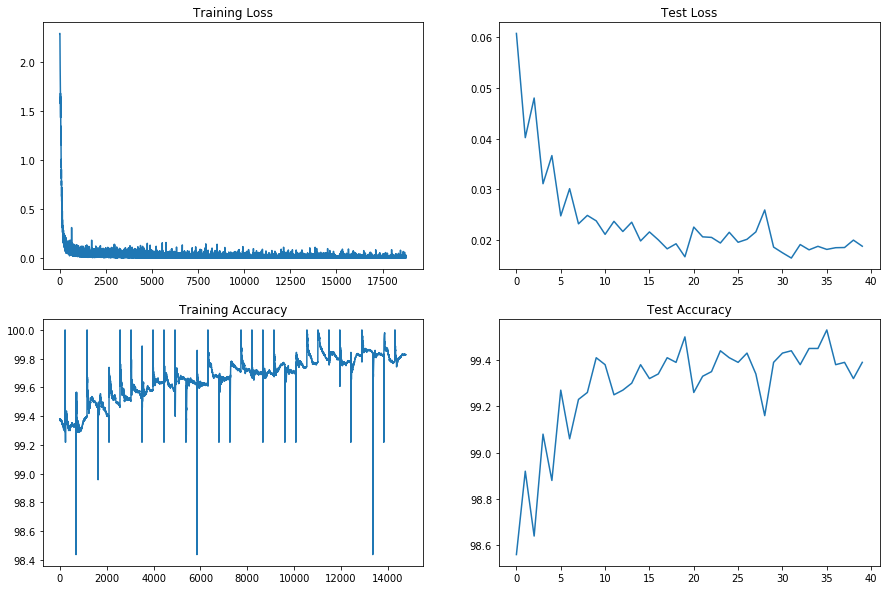

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

#plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")